# Base Model QED
This is the base setup for working on QED data.
It shows how to import the data and how to convert the expressions into different formats.

In [1]:
from icecream import ic
import sympy as sp
from itertools import (takewhile,repeat)
from tqdm import tqdm
import numpy as np
import sys
import os
import importlib.util
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
import pickle

2022-11-14 15:52:03.685003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 15:52:03.829330: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-14 15:52:03.889843: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 15:52:04.470806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
tf.config.list_physical_devices('GPU')

2022-11-14 15:52:06.033445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 15:52:06.037215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 15:52:06.037357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [4]:
import data_preprocessing.tree.sympy_to_tree as sp2tree
from data_preprocessing.sympy_prefix.source.SympyPrefix import prefix_to_sympy, sympy_to_prefix, sympy_to_hybrid_prefix, hybrid_prefix_to_sympy


In [8]:
import re
def fix_i(expr_str):
    reg_ex = "[^a-z]i[^a-z,^\d]"
    replaced = re.sub(reg_ex, fix_i_match, expr_str)
    return replaced
    
def fix_i_match(matchobj):
    """
    i --> I
    """
    match = matchobj.group(0)
    return match.replace("i", "I")


def rawincount(filename):
    """count numer of lines in a file. 
    From https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python
    """
    f = open(filename, 'rb')
    bufgen = takewhile(lambda x: x, (f.raw.read(1024*1024) for _ in repeat(None)))
    return sum( buf.count(b'\n') for buf in bufgen )

def load_raw_amplitudes(filename, max_lines=-1):
    """
    Loading raw amplitudes from filename.
    
    Options:
        - `max_lines`: maximum number of lines to read
    """
    print("Loading amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines, leave=False)
    with open(filename) as f:
        line = f.readline()
        ctr = 0
        data[ctr] = line.replace("\n", "")
        while line:
            line = f.readline()
            if line != "":
                data[ctr] = line.replace("\n", "")
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data


def load_squared_amplitudes(filename, max_lines=-1):
    """
    Loading squared amplitudes from filename and parsing into sympy.
    All squared amplitudes should be exportet from sympy and thus be readable
    without any preprocessing.

    Options:
        - `max_lines`: maximum number of lines to read

    Returns:
        list of squared amplitudes, each as a sympy expression
    """
    print("Loading squared amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines, leave=False)
    with open(filename) as f:
       line = f.readline()
       line_sp = sp.sympify(line.strip())
       ctr = 0
       data[ctr] = line_sp
       while line:
            line = f.readline()
            if line != "":
                line = line.strip()
                line = fix_i(line)
                line_sp = sp.sympify(line.strip())
                data[ctr] = line_sp
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data

In [9]:
data_folder = "../data_unique.nosync/"
amplitudes_filename_start = "QED_amplitudes_TreeLevel_"
sqamplitudes_filename_start = "QED_sqamplitudes_TreeLevel_"
processes = ["1to2", "2to1", "2to2", "2to3", "3to2", "3to3"]
max_lines = -1

amplitudes = []
sqamplitudes = []
for process in processes:
    ampl_f = data_folder + amplitudes_filename_start + process + ".txt"
    sqampl_f = data_folder + sqamplitudes_filename_start + process + ".txt"
    amplitudes_process = load_raw_amplitudes(ampl_f, max_lines=max_lines)
    sqamplitudes_process = load_squared_amplitudes(sqampl_f, max_lines=max_lines)
    amplitudes.append(amplitudes_process)
    sqamplitudes.append(sqamplitudes_process)

Loading amplitudes from ../data_unique.nosync/QED_amplitudes_TreeLevel_1to2.txt


  0%|          | 0/6 [00:00<?, ?it/s]

Loading squared amplitudes from ../data_unique.nosync/QED_sqamplitudes_TreeLevel_1to2.txt


  0%|          | 0/6 [00:00<?, ?it/s]

Loading amplitudes from ../data_unique.nosync/QED_amplitudes_TreeLevel_2to1.txt


  0%|          | 0/6 [00:00<?, ?it/s]

Loading squared amplitudes from ../data_unique.nosync/QED_sqamplitudes_TreeLevel_2to1.txt


  0%|          | 0/6 [00:00<?, ?it/s]

Loading amplitudes from ../data_unique.nosync/QED_amplitudes_TreeLevel_2to2.txt


  0%|          | 0/28 [00:00<?, ?it/s]

Loading squared amplitudes from ../data_unique.nosync/QED_sqamplitudes_TreeLevel_2to2.txt


  0%|          | 0/28 [00:00<?, ?it/s]

Loading amplitudes from ../data_unique.nosync/QED_amplitudes_TreeLevel_2to3.txt


  0%|          | 0/128 [00:00<?, ?it/s]

Loading squared amplitudes from ../data_unique.nosync/QED_sqamplitudes_TreeLevel_2to3.txt


  0%|          | 0/128 [00:00<?, ?it/s]

Loading amplitudes from ../data_unique.nosync/QED_amplitudes_TreeLevel_3to2.txt


  0%|          | 0/128 [00:00<?, ?it/s]

Loading squared amplitudes from ../data_unique.nosync/QED_sqamplitudes_TreeLevel_3to2.txt


  0%|          | 0/128 [00:00<?, ?it/s]

Loading amplitudes from ../data_unique.nosync/QED_amplitudes_TreeLevel_3to3.txt


  0%|          | 0/1040 [00:00<?, ?it/s]

Loading squared amplitudes from ../data_unique.nosync/QED_sqamplitudes_TreeLevel_3to3.txt


  0%|          | 0/1040 [00:00<?, ?it/s]

We will keep the different amplitudes separated for now, so `amplitudes` has the form
`[multiplicity, i]` where `multiplicity = ["1to2", "2to1", ...]`.

In [11]:
# the amplitudes are in prefix format
print(len(amplitudes))
print(len(sqamplitudes))
print(len(amplitudes[0]))
print(len(sqamplitudes[0]))
print(len(amplitudes[1]))
print(len(sqamplitudes[1]))
print(len(amplitudes[2]))
print(len(sqamplitudes[2]))
print(len(amplitudes[3]))
print(len(sqamplitudes[3]))
print(len(amplitudes[4]))
print(len(sqamplitudes[4]))
print(len(amplitudes[5]))
print(len(sqamplitudes[5]))

6
6
5
5
5
5
27
27
127
127
127
127
1039
1039


In [12]:
amplitudes[0][0]

'Prod,-1,Prod,i,Prod,e,Prod,gamma,alpha_2,alpha_0,alpha_1,Prod,A^(*),i_2,alpha_2,(p_3),Prod,ee,i_0,alpha_1,(p_1)_u,ee^(*),i_1,alpha_0,(p_2)_u'

In [13]:
sqamplitudes[0][0]

-4*e**2*(2*m_e**2 - s_12)

In [15]:
# convert squared ampmlitudes to prefix
ctr = 0
def try_sympy_to_prefix(expr):
    global ctr
    ctr = ctr + 1
    try:
        return sympy_to_prefix(expr)
    except:
        print("problem with:", expr, "at ctr =", ctr)
        return 0
sqampl_prefix = [[try_sympy_to_prefix(a) for a in tqdm(sq, leave=False)] for sq in sqamplitudes]
np.array(sqampl_prefix[0][0])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/1039 [00:00<?, ?it/s]

array(['mul', 's-', '4', 'mul', 'pow', 'e', '2', 'add', 'mul', 's-', '1',
       's_12', 'mul', '2', 'pow', 'm_e', '2'], dtype='<U4')

In [16]:
# convert squared amplitudes to trees:
ctr = 0
def try_sympy_to_tree(expr):
    global ctr
    ctr = ctr + 1
    try:
        return sp2tree.sympy_to_tree(expr)
    except:
        print("problem with:", expr, "at ctr =", ctr)
        return 0
sqampl_tree = [[try_sympy_to_tree(a) for a in tqdm(sq, leave=False)] for sq in sqamplitudes]
display(sqamplitudes[2][0])
sqampl_tree[2][0].pretty_print(unicodelines=True)

# convert back
print("tree_to_sympy:")
display(sp2tree.tree_to_sympy(sqampl_tree[2][0]))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/1039 [00:00<?, ?it/s]

8*e**4*(2*m_e**4 + m_e**2*(-s_13 - s_24) + s_12*s_34 + s_14*s_23)/(2*m_e**2 + reg_prop - 2*s_13)**2

                                                              mul                                                                              
 ┌───────┬─────────────┬───────────────────────────────────────┴──────────────────────────────────┐                                             
 │       │            pow                                                                        add                                           
 │       │       ┌─────┴──────────────┐                        ┌────────────────┬─────────────┬───┴────────────────┐                            
 │       │       │                   add                       │                │             │                   mul                          
 │       │       │     ┌──────────┬───┴────────┐               │                │             │            ┌───────┴────────────┐               
 │       │       │     │          │           mul             mul               │             │            │                   add   

8*e**4*(2*m_e**4 + m_e**2*(-s_13 - s_24) + s_12*s_34 + s_14*s_23)/(2*m_e**2 + reg_prop - 2*s_13)**2

# Export everything
Loading and converting takes quite long. Let's export everything for easy reloading.

In [17]:
export_folder = "../data.nosync/2022-11-14/"
with open(export_folder+"amplitudes.pickle", "wb") as f:
    pickle.dump(amplitudes, f)

with open(export_folder+"sqamplitudes.pickle", "wb") as f:
    pickle.dump(sqamplitudes, f)

In [18]:
with open(export_folder+"amplitudes.pickle", "rb") as f:
    amplitudes = pickle.load(f)
    amplitudes = [[a.split(",") for a in amps] for amps in amplitudes]

with open(export_folder+"sqamplitudes.pickle", "rb") as f:
    sqamplitudes = pickle.load(f)

# Prefix Model

In this base model we will be using prefix notation for the amplitudes and squared amplitudes

In [19]:
X_train = []
X_test = []
y_train = []
y_test = []
X_val = []
y_val = []
X_tmp = []
y_tmp = []
for a, s in zip(amplitudes, sqampl_prefix):
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
        a, s, test_size=0.1, random_state=42
    )
    X_train = X_train + X_train_i
    X_tmp = X_tmp + X_test_i
    y_train = y_train + y_train_i
    y_tmp = y_tmp + y_test_i

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42
)
X_val = X_val + X_train_i
X_test = X_test + X_test_i
y_val = y_val + y_train_i
y_test = y_test + y_test_i

del X_tmp, y_tmp

In [20]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))


1195
1195
67
67
68
68


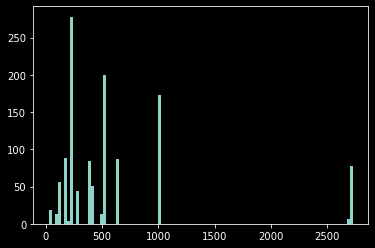

In [21]:
plt.hist([len(x) for x in X_train], bins=100);

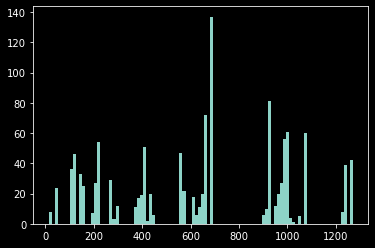

In [22]:
plt.hist([len(y) for y in y_train], bins=100);

Only use those X,y where both are at most `sequence_length` long.

In [24]:
vocab_size = 500
sequence_length = 650
batch_size = 1

X_train_idx_okay = np.where([len(x) < sequence_length for x in X_train])[0]
y_train_idx_okay = np.where([len(y) < sequence_length for y in y_train])[0]
X_val_idx_okay = np.where([len(x) < sequence_length for x in X_val])[0]
y_val_idx_okay = np.where([len(x) < sequence_length for x in y_val])[0]
X_test_idx_okay = np.where([len(x) < sequence_length for x in X_test])[0]
y_test_idx_okay = np.where([len(x) < sequence_length for x in y_test])[0]


train_idx_okay = np.intersect1d(X_train_idx_okay, y_train_idx_okay) 
val_idx_okay = np.intersect1d(X_val_idx_okay, y_val_idx_okay) 
test_idx_okay = np.intersect1d(X_test_idx_okay, y_test_idx_okay) 
print("X okay:", len(X_train_idx_okay) / len(X_train))
print("y okay:", len(y_train_idx_okay) / len(y_train))

X okay: 0.7841004184100419
y okay: 0.45523012552301256


In [80]:
X_train_short = [X_train[i] for i in train_idx_okay]
y_train_short = [y_train[i] for i in train_idx_okay]

X_val_short = [X_val[i] for i in val_idx_okay]
y_val_short = [y_val[i] for i in val_idx_okay]

X_test_short = [X_test[i] for i in test_idx_okay]
y_test_short = [y_test[i] for i in test_idx_okay]


# Data Augmentation

In [29]:
def get_unique_indices(amps):
    amps = [" ".join(a) for a in amps]
    tmp = np.sort(np.unique(amps, return_index=True, axis=0)[1])
    return tmp

In [45]:
ic(len(get_unique_indices(X_train_short)));
ic(len(X_train_short));

ic| len(get_unique_indices(X_train_short)): 460
ic| len(X_train_short): 460


In [46]:
ic(len(get_unique_indices(y_train_short)));
ic(len(y_train_short));

ic| len(get_unique_indices(y_train_short)): 238
ic| len(y_train_short): 460


In [104]:
def augment_diagram(x, y, new_electrons = ["mu", "tau", "up", "down", "strange", "charm", "top", "bottom"]):
    """
    This does some augmentation by switching all electrons to muons etc.
    Note that it is not so easy to only switch one electron in a process to say a muon.
    """
    X_aug = []
    y_aug = []
    for e in new_electrons:
        x_new = [xx.replace("ee", e) for xx in x]
        y_new = [yy.replace("m_e", "m_"+e) for yy in y]
        X_aug.append(x_new)
        y_aug.append(y_new)
    return X_aug, y_aug

def augment_data(X, y, new_electrons = ["mu", "tau", "up", "down", "strange", "charm", "top", "bottom"]):
    X_aug = []
    y_aug = []
    for x, y in zip(X_train_short, y_train_short):
        new_data = augment_diagram(x, y, new_electrons=new_electrons)
        X_aug = X_aug + new_data[0]
        y_aug = y_aug + new_data[1]
    return X_aug, y_aug

In [111]:
augmentation_data = augment_data(X_train_short, y_train_short)

In [112]:
len(X_train_short)*8

3680

In [113]:
len(augmentation_data[0])

3680

In [121]:
np.array(X_train_short[25])

array(['Prod', 'i', 'Prod', 'Pow', 'e', '2', 'Prod', 'Pow', 'Sum', 's_23',
       'Prod', '-1/2', 'reg_prop', '-1', 'Sum', 'Prod', 'p_1', 'alpha_7',
       'Prod', 'gamma', 'alpha_8', 'alpha_2', 'alpha_0', 'Prod', 'A',
       'i_3', 'alpha_8', '(p_3)', 'Prod', 'A', 'i_1', 'alpha_7', '(p_4)',
       'Prod', 'ee^(*)', 'i_0', 'alpha_2', '(p_1)_u', 'ee', 'i_2',
       'alpha_0', '(p_2)_v', 'Prod', '-1/2', 'Prod', 'p_4', 'alpha_6',
       'Prod', 'gamma', 'alpha_6', 'alpha_4', 'alpha_5', 'Prod', 'gamma',
       'alpha_7', 'alpha_3', 'alpha_4', 'Prod', 'gamma', 'alpha_8',
       'alpha_5', 'alpha_1', 'Prod', 'A', 'i_3', 'alpha_8', '(p_3)',
       'Prod', 'A', 'i_1', 'alpha_7', '(p_4)', 'Prod', 'ee^(*)', 'i_0',
       'alpha_3', '(p_1)_u', 'ee', 'i_2', 'alpha_1', '(p_2)_v'],
      dtype='<U8')

In [122]:
hybrid_prefix_to_sympy(y_train_short[0])

4*e**2*(2*m_e**2 + s_12)

In [124]:
hybrid_prefix_to_sympy(augmentation_data[1][0])

4*e**2*(2*m_mu**2 + s_12)

In [125]:
X_train_text = [" ".join(x) for x in X_train_short+augmentation_data[0]]
y_train_text = [" ".join(yy) for yy in y_train_short+augmentation_data[1]]

X_val_text = [" ".join(x) for x in X_val_short]
y_val_text = [" ".join(yy) for yy in y_val_short]

X_test_text = [" ".join(x) for x in X_test_short]
y_test_text = [" ".join(yy) for yy in y_test_short]

In [126]:
export_folder

'../data.nosync/2022-11-14/'

In [127]:
# reading to sympy takes quite long.
# We're here caching the alreaday converted amplitudes
X_train_cache_file = export_folder+"X_train.pickle"
y_train_cache_file = export_folder+"y_train.pickle"
X_val_cache_file = export_folder+"X_val.pickle"
y_val_cache_file = export_folder+"y_val.pickle"
X_test_cache_file = export_folder+"X_test.pickle"
y_test_cache_file = export_folder+"y_test.pickle"

if os.path.exists(X_train_cache_file) & os.path.exists(y_train_cache_file):
    print("Exists, loading")
    with open(X_train_cache_file, "rb") as f:
        X_train_text = pickle.load(f)
    with open(X_train_cache_file, "rb") as f:
        y_train_text = pickle.load(f)

else:
    with open(X_train_cache_file, "wb") as f:
        pickle.dump(X_train_text, f)
    with open(y_train_cache_file, "wb") as f:
        pickle.dump(y_train_text, f)

if os.path.exists(X_val_cache_file) & os.path.exists(y_val_cache_file):
    print("Exists, loading")
    with open(X_val_cache_file, "rb") as f:
        X_val_text = pickle.load(f)
    with open(X_val_cache_file, "rb") as f:
        y_val_text = pickle.load(f)

else:
    with open(X_val_cache_file, "wb") as f:
        pickle.dump(X_val_text, f)
    with open(y_val_cache_file, "wb") as f:
        pickle.dump(y_val_text, f)

if os.path.exists(X_test_cache_file) & os.path.exists(y_test_cache_file):
    print("Exists, loading")
    with open(X_test_cache_file, "rb") as f:
        X_test_text = pickle.load(f)
    with open(X_test_cache_file, "rb") as f:
        y_test_text = pickle.load(f)

else:
    with open(X_test_cache_file, "wb") as f:
        pickle.dump(X_test_text, f)
    with open(y_test_cache_file, "wb") as f:
        pickle.dump(y_test_text, f)


# Vectorization

In [128]:
def custom_standardization(input_string):
    return input_string

X_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=None,
)

y_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length+1,
    standardize=None,
)

X_vectorization.adapt(X_train_text)
y_vectorization.adapt(y_train_text)

2022-11-14 16:49:12.031985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 16:49:12.032863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:49:12.033042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:49:12.033118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [129]:
def format_dataset(X, y):
    X_vec = X_vectorization(X)
    y_vec = y_vectorization(y)
    return (
        {
            "encoder_inputs": X_vec,
            "decoder_inputs": y_vec[:, :-1],
        },
        y_vec[:, 1:],
    )


def make_dataset(X_text, y_text):
    dataset = tf.data.Dataset.from_tensor_slices((X_text, y_text))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(X_train_text, y_train_text)
val_ds = make_dataset(X_val_text, y_val_text)
test_ds = make_dataset(X_test_text, y_test_text)

In [130]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (1, 650)
inputs["decoder_inputs"].shape: (1, 650)
targets.shape: (1, 650)


2022-11-14 16:49:15.149374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [131]:
ctr = 0
tmp = []
for x in train_ds.as_numpy_iterator():
    tmp.append(x)
    ctr += 1

In [132]:
ctr

4140

In [133]:
len(X_train_text)

4140

In [134]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [135]:
embed_dim = 128 # 256  # 512
latent_dim = 1024 #2048  # 16384
num_heads = 8

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 128)   147200      ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 128)   791296      ['positional_embedding[

Text(0, 0.5, 'learning rate')

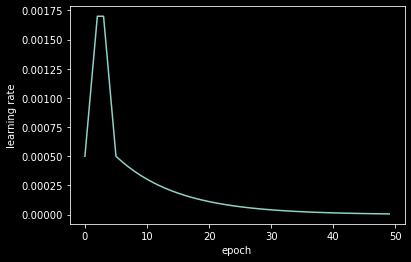

In [147]:
def learning_rate_cyclic(epoch):
    initial_lr = 0.0005
    max_lr = 0.002
    max_epochs = 5
    if epoch <= (max_epochs / 2):
        lr = initial_lr + (max_lr-initial_lr) * epoch/(max_epochs/2)
        return lr
    if (epoch > (max_epochs / 2)) & (epoch < max_epochs):
        lr = max_lr - (max_lr-initial_lr) * (epoch-max_epochs/2)/(max_epochs/2)
        return lr
    else:
        lr = initial_lr*np.exp(-(epoch-max_epochs)/10)
        return lr

xrange = range(0,50)
yrange = [learning_rate_cyclic(x) for x in xrange]
plt.plot(xrange, yrange)
plt.xlabel("epoch")
plt.ylabel("learning rate")

In [148]:
epochs = 30  # This should be at least 30 for convergence
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_cyclic)
checkpoint = keras.callbacks.ModelCheckpoint(
    "models/2022-11-14-Transformer_upto3to3_unique_augmented", save_best_only=True, monitor="val_loss", save_weights_only=True
)

callbacks = [lr_schedule, checkpoint]

transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds,
                          callbacks = callbacks)


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 128)   147200      ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 128)   791296      ['positional_embedding[

In [150]:
transformer.load_weights("models/2022-11-14-Transformer_upto3to3_unique_augmented")

In [151]:
y_vocab = y_vectorization.get_vocabulary()
y_index_lookup = dict(zip(range(len(y_vocab)), y_vocab))
max_decoded_sentence_length = 350


def decode_sequence(input_sentence):
    tokenized_input_sentence = X_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = y_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = y_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[END]":
            break
    return decoded_sentence

In [152]:
%%time
decode_sequence(X_train_text[0])

CPU times: user 8.07 s, sys: 307 ms, total: 8.38 s
Wall time: 8.08 s


'[start] s- 2 mul pow e 2 add mul s- 1 s_12 mul 2 pow m_down 2  add add add 2 add mul add s_25  s_14 add s_25 s_13 s_14 add add s_14 2 mul mul s_14 mul mul 2   s_13 mul s_15  s_25  mul 2 s_34 s_13 s_25 mul s_24 s_23 2 s_34 s_15 s_15 s_15 s_13 add s_23 add s_14 pow s_14 s_34 s_34 s_34 s_34  s_23 2 4 s_45 add s_14 s- s_12 s_25 add s_34 add add add add 2 add s_35 2 4 add mul mul add s_24 s- s_13 mul 2 mul s_12 s_15 2 s_24 mul mul mul  s_12 s_14 s_14  s_14  mul s_16 mul 2 mul s_12 mul 2  pow s_34 s_24 s_24 pow  s_34 s_13  8 s_45 add 2 add 2 mul s_14 mul s_25 mul  s_45 add  mul add s_14 s_14 2  mul s_34  s_13 s_12 mul s_15 mul  s_35 s_34 2 mul s_25 s_45 s_12 s_12 s_14 s_13 s_34 2 s_34 s_13 mul s_14 s_23 add s_34 s_13 s_45 mul s_15 add s_23 s- mul mul mul s_14 mul s_23 s-  s_34  s_45  mul  s_15 mul s_56 mul mul mul 1 s_45 s_15  s_35 mul mul s_14 s_25 4 s_15 mul mul s_34 2 4 mul s_24 1  add s_34 s_14 mul mul  s_45 add add mul add mul mul pow  mul 2 2 2 s_34 2 mul mul  add 2 mul mul s_23 s_35 

In [153]:
y_train_text[0]

'mul 4 mul pow e 2 add s_12 mul 2 pow m_e 2'

In [154]:
decode_sequence(X_val_text[20])

'[start] 8 mul pow e 6 mul pow add mul s- 1 reg_prop mul 2 s_14 s- 2 mul pow add reg_prop add mul s- 2 s_14 add mul s- 2 s_24 mul 2 s_12 s- 2 add mul s- 4 s_14 mul 2 add mul pow m_up 2 add mul s- 2 mul s_14 s_34 add mul s- 2 mul s_14 s_45 mul s- 2 mul 2 mul s_14 s_35 add mul s_15 s_25 add mul 4 mul s_14 s_35 add mul pow m_up 4 add mul s- 4 s_35 add mul s- 2 s_34 add mul s- 2 s_45 add mul 2 s_13 add mul 2 s_15 mul 4 s_14 mul 2 mul s_14 mul s_35 s_45  4 mul mul s_34 s_14 s_34 2 s_35 s_25 s_13 s_14 s_14 pow s_45 add s_13 s_23 mul s_45 mul s_24 s_15 s_45 mul s_14 8 s_25 mul add s_15 mul s_15 s_15 s_34 mul s_45 2 add mul s_25 s_16 s_26 s_45 mul s_56 mul s_35 s_35 s_23 s_25 mul s_23 mul s_12 add add add add mul mul s_15 mul s_15 mul add mul add s_35 add s_25 add s_45 add s_15 mul add s_13 mul s_34 s- s_15 mul  2  mul add mul mul mul s_45 s_14 mul pow mul s-  add mul s_34 s_15 s_35 4 s_35 s_15 mul s- mul mul 1 s_24 s_45 1 add s_34 s_45 s_24 mul add s_35 s_24 s_45 s_45 add mul mul s_45 s_45 mu

In [155]:
y_val_text[20]

'mul 8 mul pow e 6 mul pow add mul s- 1 reg_prop mul 2 s_14 s- 2 mul pow add reg_prop add mul s- 2 s_14 add mul s- 2 s_24 mul 2 s_12 s- 2 add mul s- 4 pow m_e 6 add mul pow m_e 2 add mul s- 2 mul s_14 s_34 add mul s- 2 mul s_14 s_45 add mul s- 2 mul s_15 s_35 add mul 2 mul s_35 s_45 mul 4 mul s_14 s_35 add mul pow m_e 4 add mul s- 4 s_35 add mul s- 2 s_34 add mul s- 2 s_45 add mul 2 s_13 add mul 2 s_15 mul 4 s_14 mul 2 mul s_14 mul s_35 s_45'